In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib
import common_utils 

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5, num_images=50, 
                        brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

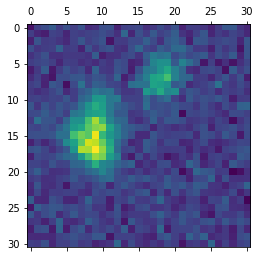

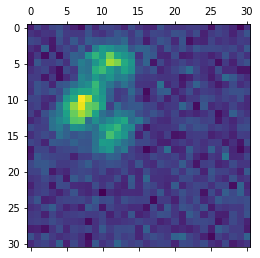

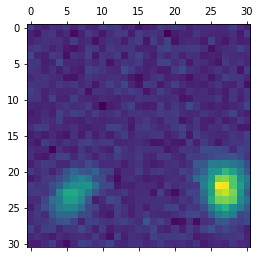

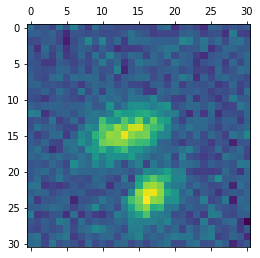

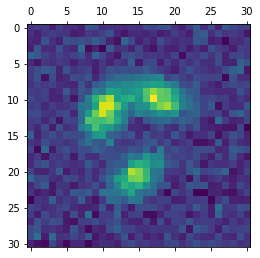

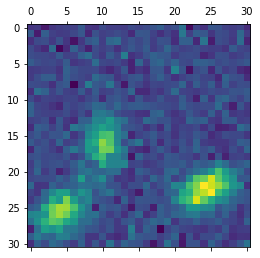

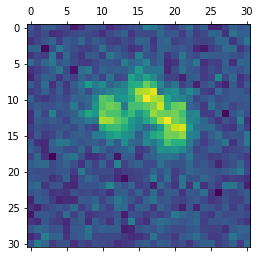

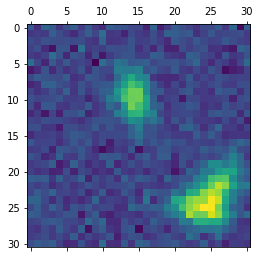

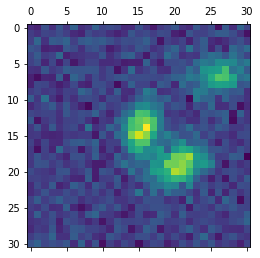

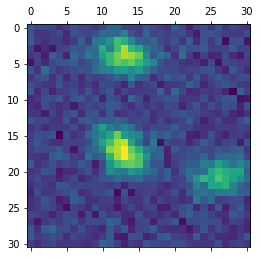

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset=4, prob_off=0)

(array([422.,  20.,   9.,  11.,   6.,   5.,   4.,   5.,   4.,   6.,   4.,
          4.,   2.,   3.,   5.,   1.,   2.,   2.,   3.,   6.,   0.,   2.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.00099213, 0.00198426, 0.00297639, 0.00396852,
        0.00496065, 0.00595278, 0.00694491, 0.00793704, 0.00892917,
        0.00992131, 0.01091344, 0.01190557, 0.0128977 , 0.01388983,
        0.01488196, 0.01587409, 0.01686622, 0.01785835, 0.01885048,
        0.01984261, 0.02083474, 0.02182687, 0.022819  , 0.02381113,
        0.02480326, 0.02579539, 0.02678752, 0.02777966, 0.02877179,
        0.02976392]),
 <a list of 30 Patch objects>)

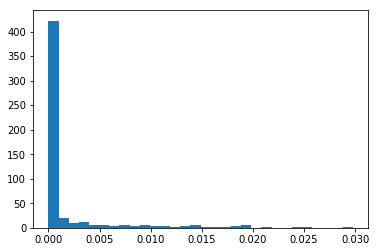

In [8]:
vec = imp_weights[2, :]
plt.hist(vec, bins = 30)

In [9]:
imp_weights

tensor(1.00000e-02 *
       [[ 0.0061,  0.0326,  0.0082,  ...,  0.0000,  0.0196,  0.0000],
        [ 0.0352,  0.0675,  0.1182,  ...,  0.0157,  0.0100,  0.0000],
        [ 0.0233,  0.0315,  0.0268,  ...,  0.7511,  1.0930,  0.0000],
        ...,
        [ 0.0112,  0.0125,  0.0384,  ...,  1.7588,  1.3180,  0.0000],
        [ 0.0648,  0.0357,  0.0332,  ...,  0.0155,  0.0000,  0.0000],
        [ 0.0186,  0.0143,  0.0800,  ...,  0.0173,  0.0270,  0.0000]])

In [10]:
torch.min(imp_weights)

tensor(0.)

# The VAE

In [11]:
one_galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [12]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

one_galaxy_vae.eval(); 

In [13]:
galaxy_vae = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=one_galaxy_vae)

In [14]:
pixel_probs = galaxy_vae.get_pixel_probs(images_batch1, backgrounds_batch1)

In [15]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [16]:
recon_mean, recon_var, is_on, kl_z = galaxy_vae.sample_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [17]:
map_pixel_loc

tensor([ 306,  167,  442,  452,  178,  436,   94,  505,  244,  334])

In [18]:
is_on

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

(array([  1.,   0.,   0.,   0.,   1.,  13.,  37., 335., 135.,   8.]),
 array([1.04095201e-16, 2.45162100e-04, 4.90324199e-04, 7.35486299e-04,
        9.80648398e-04, 1.22581050e-03, 1.47097260e-03, 1.71613470e-03,
        1.96129680e-03, 2.20645890e-03, 2.45162100e-03]),
 <a list of 10 Patch objects>)

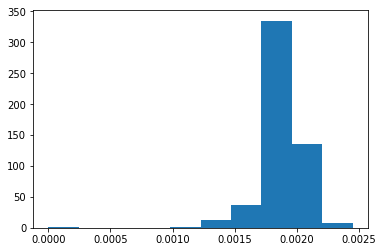

In [19]:
plt.hist(pixel_probs[0, :].detach())

In [20]:
recon_mean.sum()

tensor(756.2807)

In [21]:
recon_var.sum()

tensor(4526.5122)

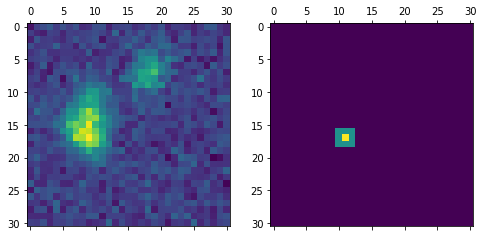

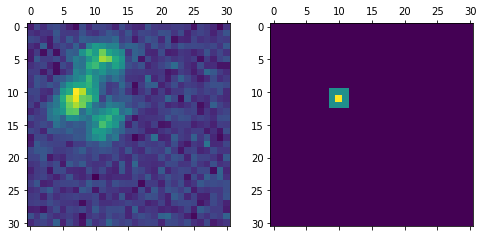

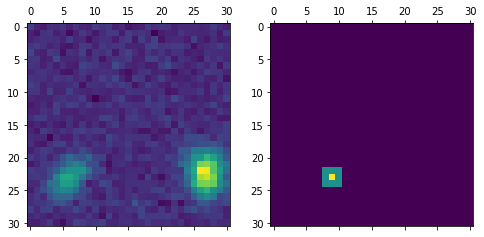

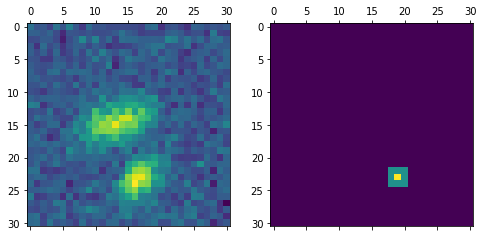

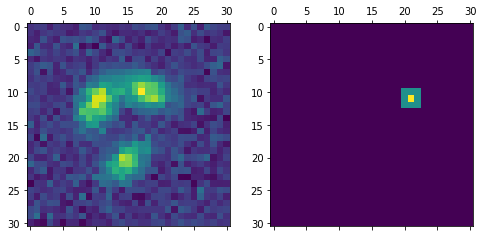

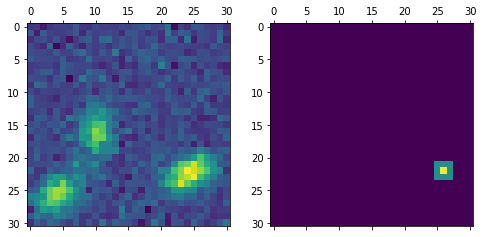

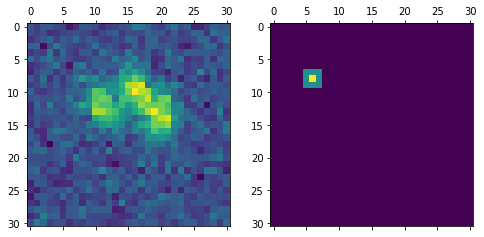

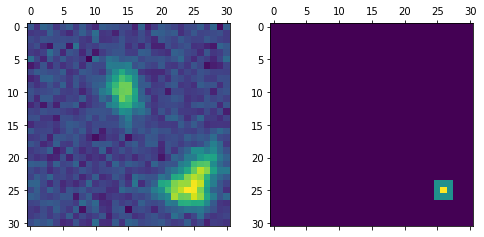

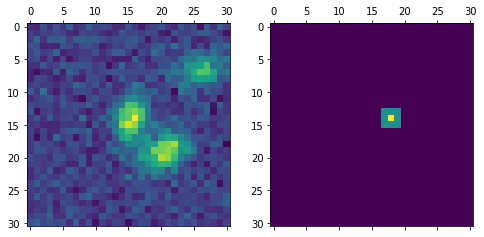

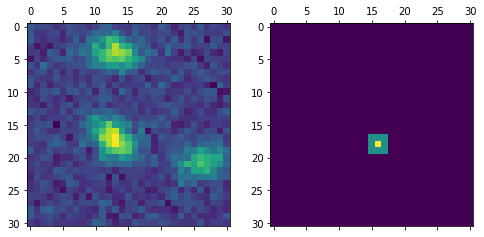

In [22]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


# Experimenting with new importance sampling functions

In [23]:
# function to normalize image
attn_offset = galaxy_vae.attn_offset
# normalized_image = imp_lib.crop_and_normalize_image(images_batch1, attn_offset)

In [24]:
# normalized_image.sum(dim = 1).sum(dim = 1) - 1

In [25]:
# append probability of being off
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [26]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

1.1920929e-06

In [27]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[3.5762787e-07 2.9802322e-07 3.5762787e-07 1.1920929e-07 1.1920929e-06
 4.7683716e-07 1.1920929e-07 2.3841858e-07 4.7683716e-07 4.1723251e-07]


In [28]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

AssertionError: 

In [ ]:
# visually check importance weights: 

In [ ]:
prob_off = torch.zeros((images_batch1.shape[0], 1)) # pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset, prob_off)

In [ ]:
which_n = 1
image_sampled = torch.zeros((side_len, side_len))
for i in range(10000): 
    z_sample = common_utils.sample_class_weights(importance_weights)
    pixel_2d = galaxy_vae.one_galaxy_vae.pixel_1d_to_2d(z_sample)
    image_sampled[pixel_2d[which_n, 0], pixel_2d[which_n, 1]] += 1

In [ ]:
plt.hist(importance_weights[which_n, :])

In [ ]:
imp_weights_grid = importance_weights[:, 0:-1].view(images_batch1.shape[0], 23, 23)
plt.matshow(imp_weights_grid.detach()[which_n, :, :])

In [ ]:
plt.matshow(image_sampled)

In [ ]:
plt.matshow(images_batch1[which_n, 0, :, :])

In [ ]:
# check optimizer goes through

In [ ]:
optimizer = optim.Adam(galaxy_vae.parameters(), lr=0.01, weight_decay=1e-6)
optimizer.zero_grad()

In [ ]:
pm_loss, neg_elbo, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

In [ ]:
# check params
all_params = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params = torch.cat([params, all_params])

In [ ]:
pm_loss

In [ ]:
pm_loss.backward()

In [ ]:
optimizer.step()

In [ ]:
_, neg_elbo2, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

In [ ]:
neg_elbo2

In [ ]:
# check params
all_params2 = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params2 = torch.cat([params, all_params2])

In [ ]:
torch.max(all_params2 - all_params)

In [ ]:
plt.hist((all_params2 - all_params).detach())

In [ ]:
# Check train module

In [ ]:
# train_module(vae, train_loader, test_loader, epochs,
#                         use_baseline = True,
#                         use_importance_sample = True,
#                         lr = 1e-4, weight_decay = 1e-6,
#                         save_every = 10,
#                         filename = './galaxy_vae_params',
#                         seed = 245345)

In [ ]:
imp_lib.train_module(galaxy_vae, train_loader, test_loader, 
                        epochs = 12, save_every = 2, 
                        use_baseline = True, 
                        use_importance_sample = True, 
                        max_detections = 2, 
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

In [ ]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [ ]:
galaxy_vae_reload

In [ ]:
np.load('./test_test_losses_array.npy')